## Kiva Crowdfunding Loan Type Prediction

Given *data about Kiva crowdfunding loans*, let's try to predict the **type** of a given loan.

We will use a tensorflow neural network to make our predictions. 

Data source: https://www.kaggle.com/datasets/kiva/data-science-for-good-kiva-crowdfunding

### Getting Started 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn. preprocessing import StandardScaler

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

pd.set_option('display.max_columns', None)

2024-11-13 13:03:25.939088: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv("kiva_loans.csv")
data.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671205 entries, 0 to 671204
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  671205 non-null  int64  
 1   funded_amount       671205 non-null  float64
 2   loan_amount         671205 non-null  float64
 3   activity            671205 non-null  object 
 4   sector              671205 non-null  object 
 5   use                 666973 non-null  object 
 6   country_code        671197 non-null  object 
 7   country             671205 non-null  object 
 8   region              614405 non-null  object 
 9   currency            671205 non-null  object 
 10  partner_id          657698 non-null  float64
 11  posted_time         671205 non-null  object 
 12  disbursed_time      668809 non-null  object 
 13  funded_time         622874 non-null  object 
 14  term_in_months      671205 non-null  float64
 15  lender_count        671205 non-nul

### Helper Functions

In [4]:
def encode_dates(df, column):
    df = df.copy()

    df[column] = pd.to_datetime(df[column])

    df[column + '_year'] = df[column].apply(lambda x: x.year)
    df[column + '_month'] = df[column].apply(lambda x: x.month)
    df[column + '_day'] = df[column].apply(lambda x: x.day)
    df[column + '_hour'] = df[column].apply(lambda x: x.hour)
    df[column + '_minute'] = df[column].apply(lambda x: x.minute)

    df = df.drop(column, axis=1)
    
    return df

In [5]:
def get_male_count(x):
    count = 0
    for gender in str(x).split(', '):
        if gender == 'male':
            count += 1
    return count
            
def get_female_count(x):
    count = 0
    for gender in str(x).split(', '):
        if gender == 'female':
            count += 1
    return count

In [6]:
def onehot_encode(df, columns_with_prefixes):
    df = df.copy()
    for column, prefix in columns_with_prefixes:
        dummies = pd.get_dummies(df[column], prefix=prefix, dtype=np.int16)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [7]:
def reduce_memory_size(df, columns): 
    df = df.copy()
    for column in columns:
        if str(df[column].dtype) == 'float64':
            df[column] = df[column].astype(np.float32)
        if str(df[column].dtype) == 'int64':
            df[column] = df[column].astype(np.int32)
    return df

### Preprocessing

In [8]:
df = data.copy()

# Drop the 'id' column 
df = df.drop('id', axis=1)

# Drop 'use' and 'tags' columns (avoiding NLP)
df = df.drop(['use', 'tags'], axis=1)

# Drop the 'country' and 'date' columns (redundant information)
df = df.drop(['country', 'date'], axis=1)

# Drop 'region' column (high cardinality, shortage of ram resources)
df = df.drop(['region', 'partner_id', 'activity'], axis=1)

In [9]:
# Extract date features 
df = encode_dates(df, column='posted_time')
df = encode_dates(df, column='disbursed_time')
df = encode_dates(df, column='funded_time')

In [10]:
df.head()

,funded_amount,loan_amount,sector,country_code,currency,term_in_months,lender_count,borrower_genders,repayment_interval,posted_time_year,posted_time_month,posted_time_day,posted_time_hour,posted_time_minute,disbursed_time_year,disbursed_time_month,disbursed_time_day,disbursed_time_hour,disbursed_time_minute,funded_time_year,funded_time_month,funded_time_day,funded_time_hour,funded_time_minute
0,300.0,300.0,Food,PK,PKR,12.0,12,female,irregular,2014,1,1,6,12,2013.0,12.0,17.0,8.0,0.0,2014.0,1.0,2.0,10.0,6.0
1,575.0,575.0,Transportation,PK,PKR,11.0,14,"female, female",irregular,2014,1,1,6,51,2013.0,12.0,17.0,8.0,0.0,2014.0,1.0,2.0,9.0,17.0
2,150.0,150.0,Transportation,IN,INR,43.0,6,female,bullet,2014,1,1,9,58,2013.0,12.0,17.0,8.0,0.0,2014.0,1.0,1.0,16.0,1.0
3,200.0,200.0,Arts,PK,PKR,11.0,8,female,irregular,2014,1,1,8,3,2013.0,12.0,24.0,8.0,0.0,2014.0,1.0,1.0,13.0,0.0
4,400.0,400.0,Food,PK,PKR,14.0,16,female,monthly,2014,1,1,11,53,2013.0,12.0,17.0,8.0,0.0,2014.0,1.0,1.0,19.0,18.0


In [11]:
# Engineer gender count features
df['male_count'] = df['borrower_genders'].apply(get_male_count)
df['female_count'] = df['borrower_genders'].apply(get_female_count)
df = df.drop('borrower_genders', axis=1)
df

,funded_amount,loan_amount,sector,country_code,currency,term_in_months,lender_count,repayment_interval,posted_time_year,posted_time_month,posted_time_day,posted_time_hour,posted_time_minute,disbursed_time_year,disbursed_time_month,disbursed_time_day,disbursed_time_hour,disbursed_time_minute,funded_time_year,funded_time_month,funded_time_day,funded_time_hour,funded_time_minute,male_count,female_count
0,300.0,300.0,Food,PK,PKR,12.0,12,irregular,2014,1,1,6,12,2013.0,12.0,17.0,8.0,0.0,2014.0,1.0,2.0,10.0,6.0,0,1
1,575.0,575.0,Transportation,PK,PKR,11.0,14,irregular,2014,1,1,6,51,2013.0,12.0,17.0,8.0,0.0,2014.0,1.0,2.0,9.0,17.0,0,2
2,150.0,150.0,Transportation,IN,INR,43.0,6,bullet,2014,1,1,9,58,2013.0,12.0,17.0,8.0,0.0,2014.0,1.0,1.0,16.0,1.0,0,1
3,200.0,200.0,Arts,PK,PKR,11.0,8,irregular,2014,1,1,8,3,2013.0,12.0,24.0,8.0,0.0,2014.0,1.0,1.0,13.0,0.0,0,1
4,400.0,400.0,Food,PK,PKR,14.0,16,monthly,2014,1,1,11,53,2013.0,12.0,17.0,8.0,0.0,2014.0,1.0,1.0,19.0,18.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671200,0.0,25.0,Agriculture,PY,USD,13.0,0,monthly,2017,7,25,16,55,2017.0,7.0,25.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,0,1
671201,25.0,25.0,Agriculture,KE,KES,13.0,1,monthly,2017,7,25,6,14,2017.0,7.0,24.0,7.0,0.0,2017.0,7.0,26.0,2.0,9.0,0,1
671202,0.0,25.0,Entertainment,KE,KES,13.0,0,monthly,2017,7,26,0,2,2017.0,7.0,25.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0
671203,0.0,25.0,Agriculture,KE,KES,13.0,0,monthly,2017,7,26,6,12,2017.0,7.0,25.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,0,1


In [12]:
# One Hot Encode Nominal Features
nominal_features = [
    ('sector', 'sec'),
    ('country_code', 'ctc'),
    ('currency', 'cur')
]
df = onehot_encode(df, columns_with_prefixes=nominal_features)
df

,funded_amount,loan_amount,term_in_months,lender_count,repayment_interval,posted_time_year,posted_time_month,posted_time_day,posted_time_hour,posted_time_minute,disbursed_time_year,disbursed_time_month,disbursed_time_day,disbursed_time_hour,disbursed_time_minute,funded_time_year,funded_time_month,funded_time_day,funded_time_hour,funded_time_minute,male_count,female_count,sec_Agriculture,sec_Arts,sec_Clothing,sec_Construction,sec_Education,sec_Entertainment,sec_Food,sec_Health,sec_Housing,sec_Manufacturing,sec_Personal Use,sec_Retail,sec_Services,sec_Transportation,sec_Wholesale,ctc_AF,ctc_AL,ctc_AM,ctc_AZ,ctc_BF,ctc_BI,ctc_BJ,ctc_BO,ctc_BR,ctc_BT,ctc_BZ,ctc_CD,ctc_CG,ctc_CI,ctc_CL,ctc_CM,ctc_CN,ctc_CO,ctc_CR,ctc_DO,ctc_EC,ctc_EG,ctc_GE,ctc_GH,ctc_GT,ctc_GU,ctc_HN,ctc_HT,ctc_ID,ctc_IL,ctc_IN,ctc_IQ,ctc_JO,ctc_KE,ctc_KG,ctc_KH,ctc_LA,ctc_LB,ctc_LR,ctc_LS,ctc_MD,ctc_MG,ctc_ML,ctc_MM,ctc_MN,ctc_MR,ctc_MW,ctc_MX,ctc_MZ,ctc_NG,ctc_NI,ctc_NP,ctc_PA,ctc_PE,ctc_PH,ctc_PK,ctc_PR,ctc_PS,ctc_PY,ctc_RW,ctc_SB,ctc_SL,ctc_SN,ctc_SO,ctc_SR,ctc_SS,ctc_SV,ctc_TG,ctc_TH,ctc_TJ,ctc_TL,ctc_TR,ctc_TZ,ctc_UA,ctc_UG,ctc_US,ctc_VC,ctc_VI,ctc_VN,ctc_VU,ctc_WS,ctc_XK,ctc_YE,ctc_ZA,ctc_ZM,ctc_ZW,cur_ALL,cur_AMD,cur_AZN,cur_BIF,cur_BOB,cur_BRL,cur_BZD,cur_CLP,cur_CNY,cur_COP,cur_CRC,cur_DOP,cur_EGP,cur_EUR,cur_GEL,cur_GHS,cur_GTQ,cur_HNL,cur_HTG,cur_IDR,cur_ILS,cur_INR,cur_JOD,cur_KES,cur_KGS,cur_KHR,cur_LAK,cur_LBP,cur_LRD,cur_LSL,cur_MDL,cur_MGA,cur_MMK,cur_MNT,cur_MWK,cur_MXN,cur_MZN,cur_NAD,cur_NGN,cur_NIO,cur_NPR,cur_PEN,cur_PHP,cur_PKR,cur_PYG,cur_RWF,cur_SBD,cur_SLL,cur_SRD,cur_SSP,cur_THB,cur_TJS,cur_TRY,cur_TZS,cur_UAH,cur_UGX,cur_USD,cur_VND,cur_VUV,cur_WST,cur_XAF,cur_XCD,cur_XOF,cur_YER,cur_ZAR,cur_ZMW,cur_ZWD
0,300.0,300.0,12.0,12,irregular,2014,1,1,6,12,2013.0,12.0,17.0,8.0,0.0,2014.0,1.0,2.0,10.0,6.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,575.0,575.0,11.0,14,irregular,2014,1,1,6,51,2013.0,12.0,17.0,8.0,0.0,2014.0,1.0,2.0,9.0,17.0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,150.0,150.0,43.0,6,bullet,2014,1,1,9,58,2013.0,12.0,17.0,8.0,0.0,2014.0,1.0,1.0,16.0,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,200.0,200.0,11.0,8,irregular,2014,1,1,8,3,2013.0,12.0,24.0,8.0,0.0,2014.0,1.0,1.0,13.0,0.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,400.0,400.0,14.0,16,monthly,2014,1,1,11,53,2013.0,12.0,17.0,8.0,0.0,2014.0,1.0,1.0,19.0,18.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [13]:
# Split df into X and y
y = df['repayment_interval']
X = df.drop('repayment_interval', axis=1)

In [14]:
# Encode labels
label_mapping = {
    'bullet': 0,
    'weekly': 1,
    'monthly': 2,
    'irregular': 3
}
y = y.replace(label_mapping)

/tmp/ipykernel_11087/2716303056.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace(label_mapping)


In [15]:
# Fill in remaining missing values with column means
missing_value_columns = X.loc[:, X.isna().sum() > 0].columns
for column in missing_value_columns:
    X[column] = X[column].fillna(X[column].mean())

In [16]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

In [17]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 201362 entries, 118952 to 1751
Columns: 189 entries, funded_amount to cur_ZWD
dtypes: float64(13), int16(168), int64(8)
memory usage: 98.3 MB


In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 469843 entries, 404258 to 128037
Columns: 189 entries, funded_amount to cur_ZWD
dtypes: float64(13), int16(168), int64(8)
memory usage: 229.4 MB


In [19]:
float64_columns = X_train.select_dtypes('float64').columns
float64_columns

Index(['funded_amount', 'loan_amount', 'term_in_months', 'disbursed_time_year',
       'disbursed_time_month', 'disbursed_time_day', 'disbursed_time_hour',
       'disbursed_time_minute', 'funded_time_year', 'funded_time_month',
       'funded_time_day', 'funded_time_hour', 'funded_time_minute'],
      dtype='object')

In [20]:
# Reduce memory to perform scaling operation afterwards
X_train = reduce_memory_size(X_train, float64_columns)
X_test = reduce_memory_size(X_test, float64_columns)

In [21]:
int64_columns = X_train.select_dtypes('int64').columns
int64_columns

Index(['lender_count', 'posted_time_year', 'posted_time_month',
       'posted_time_day', 'posted_time_hour', 'posted_time_minute',
       'male_count', 'female_count'],
      dtype='object')

In [22]:
# Reduce memory to perform scaling operation afterwards
X_train = reduce_memory_size(X_train, int64_columns)
X_test = reduce_memory_size(X_test, int64_columns)

In [23]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 469843 entries, 404258 to 128037
Columns: 189 entries, funded_amount to cur_ZWD
dtypes: float32(13), int16(168), int32(8)
memory usage: 191.8 MB


In [24]:
X_train.shape

(469843, 189)

In [25]:
# Initialize the StandardScaler with partial_fit
scaler = StandardScaler()

# Define your batch size
batch_size = 50000  # Adjust based on your memory constraints

# Perform partial fit on batches of data
for start in range(0, X_train.shape[0], batch_size):
    end = start + batch_size
    batch = X_train[start:end]
    scaler.partial_fit(batch)

In [26]:
# Now transform the data in batches as well
X_train_scaled = pd.DataFrame()
X_test_scaled = pd.DataFrame()

for start in range(0, X_train.shape[0], batch_size):
    end = start + batch_size
    batch = X_train[start:end]
    X_train_scaled = pd.concat([X_train_scaled, pd.DataFrame(scaler.transform(batch), columns=batch.columns)], axis=0)

In [27]:
for start in range(0, X_test.shape[0], batch_size):
    end = start + batch_size
    batch = X_test[start:end]
    X_test_scaled = pd.concat([X_test_scaled, pd.DataFrame(scaler.transform(batch), columns=batch.columns)], axis=0)

In [28]:
X_train_scaled

,funded_amount,loan_amount,term_in_months,lender_count,posted_time_year,posted_time_month,posted_time_day,posted_time_hour,posted_time_minute,disbursed_time_year,disbursed_time_month,disbursed_time_day,disbursed_time_hour,disbursed_time_minute,funded_time_year,funded_time_month,funded_time_day,funded_time_hour,funded_time_minute,male_count,female_count,sec_Agriculture,sec_Arts,sec_Clothing,sec_Construction,sec_Education,sec_Entertainment,sec_Food,sec_Health,sec_Housing,sec_Manufacturing,sec_Personal Use,sec_Retail,sec_Services,sec_Transportation,sec_Wholesale,ctc_AF,ctc_AL,ctc_AM,ctc_AZ,ctc_BF,ctc_BI,ctc_BJ,ctc_BO,ctc_BR,ctc_BT,ctc_BZ,ctc_CD,ctc_CG,ctc_CI,ctc_CL,ctc_CM,ctc_CN,ctc_CO,ctc_CR,ctc_DO,ctc_EC,ctc_EG,ctc_GE,ctc_GH,ctc_GT,ctc_GU,ctc_HN,ctc_HT,ctc_ID,ctc_IL,ctc_IN,ctc_IQ,ctc_JO,ctc_KE,ctc_KG,ctc_KH,ctc_LA,ctc_LB,ctc_LR,ctc_LS,ctc_MD,ctc_MG,ctc_ML,ctc_MM,ctc_MN,ctc_MR,ctc_MW,ctc_MX,ctc_MZ,ctc_NG,ctc_NI,ctc_NP,ctc_PA,ctc_PE,ctc_PH,ctc_PK,ctc_PR,ctc_PS,ctc_PY,ctc_RW,ctc_SB,ctc_SL,ctc_SN,ctc_SO,ctc_SR,ctc_SS,ctc_SV,ctc_TG,ctc_TH,ctc_TJ,ctc_TL,ctc_TR,ctc_TZ,ctc_UA,ctc_UG,ctc_US,ctc_VC,ctc_VI,ctc_VN,ctc_VU,ctc_WS,ctc_XK,ctc_YE,ctc_ZA,ctc_ZM,ctc_ZW,cur_ALL,cur_AMD,cur_AZN,cur_BIF,cur_BOB,cur_BRL,cur_BZD,cur_CLP,cur_CNY,cur_COP,cur_CRC,cur_DOP,cur_EGP,cur_EUR,cur_GEL,cur_GHS,cur_GTQ,cur_HNL,cur_HTG,cur_IDR,cur_ILS,cur_INR,cur_JOD,cur_KES,cur_KGS,cur_KHR,cur_LAK,cur_LBP,cur_LRD,cur_LSL,cur_MDL,cur_MGA,cur_MMK,cur_MNT,cur_MWK,cur_MXN,cur_MZN,cur_NAD,cur_NGN,cur_NIO,cur_NPR,cur_PEN,cur_PHP,cur_PKR,cur_PYG,cur_RWF,cur_SBD,cur_SLL,cur_SRD,cur_SSP,cur_THB,cur_TJS,cur_TRY,cur_TZS,cur_UAH,cur_UGX,cur_USD,cur_VND,cur_VUV,cur_WST,cur_XAF,cur_XCD,cur_XOF,cur_YER,cur_ZAR,cur_ZMW,cur_ZWD
0,-0.501282,-0.521352,-0.086520,-0.414631,0.583263,-0.641361,-1.108166,-0.870018,0.938049,0.612006,-0.900609,0.106113,-0.367698,-0.112297,0.591514,-0.690173,0.239630,-0.139844,-0.147887,-0.367620,-0.196721,-0.605955,-0.134725,-0.227046,-0.097518,-0.219805,-0.035217,-0.505841,-0.1181,-0.230702,-0.096882,-0.239185,2.098105,-0.268585,-0.153495,-0.031203,-0.001459,-0.054649,-0.114433,-0.054236,-0.060722,-0.035967,-0.027921,-0.11509,-0.020007,0.0,-0.01353,-0.067912,-0.014296,0.0,-0.002527,-0.058106,-0.01459,-0.183591,-0.04831,-0.027265,-0.142703,-0.049728,-0.059545,-0.080432,-0.104735,-0.001459,-0.099620,-0.073007,-0.09715,-0.016572,-0.130402,-0.038378,-0.077858,-0.355969,-0.092955,-0.234024,-0.046621,-0.114633,-0.074307,-0.025192,-0.022934,-0.075042,-0.099522,-0.052958,-0.037676,-0.001459,-0.044558,-0.093235,-0.072933,-0.123247,-0.13406,-0.032179,-0.017141,-0.18565,1.782647,-0.203984,-0.010419,-0.111201,-0.134618,-0.101081,-0.028488,-0.090406,-0.069661,-0.009678,-0.017871,-0.015372,-0.25249,-0.092676,-0.016953,-0.173389,-0.06362,-0.050644,-0.08885,-0.037902,-0.177565,-0.096062,-0.00565,-0.002063,-0.128319,-0.002063,-0.105253,-0.046068,-0.058821,-0.024023,-0.033984,-0.077983,-0.054629,-0.09503,-0.054216,-0.035967,-0.105222,-0.019413,-0.01353,-0.002527,-0.013918,-0.18356,-0.04831,-0.027265,-0.049728,-0.046068,-0.047776,-0.079407,-0.104277,-0.098888,-0.070474,-0.096321,-0.0167,-0.130276,-0.077955,-0.354552,-0.090082,-0.214154,-0.046529,-0.055793,-0.072845,-0.025192,-0.022934,-0.075042,-0.052877,-0.03277,-0.044534,-0.092839,-0.072919,-0.00386,-0.123238,-0.104319,-0.032079,-0.181937,1.782657,-0.203979,-0.134577,-0.100866,-0.028488,-0.090394,-0.017871,-0.015303,-0.011301,-0.163987,-0.050644,-0.088472,-0.037902,-0.177284,-0.432722,-0.128319,-0.002063,-0.105253,-0.05985,-0.00565,-0.168469,-0.058821,-0.024023,-0.033605,-0.001459
1,-0.568331,-0.584728,-0.086520,-0.522010,0.583263,0.544460,-1.691507,-1.374886,-1.021950,0.612006,0.270950,-0.606847,-0.367698,-0.112297,0.591514,0.529131,-0.634446,0.456406,0.754247,-0.367620,-0.196721,-0.605955,-0.134725,-0.227046,-0.097518,-0.219805,-0.035217,-0.505841,-0.1181,4.334593,-0.096882,-0.239185,-0.476620,-0.268585,-0.153495,-0.031203,-0.001459,-0.054649,-0.114433,-0.054236,-0.060722,-0.035967,-0.027921,-0.11509,-0.020007,0.0,-0.0

In [29]:
X_test_scaled

,funded_amount,loan_amount,term_in_months,lender_count,posted_time_year,posted_time_month,posted_time_day,posted_time_hour,posted_time_minute,disbursed_time_year,disbursed_time_month,disbursed_time_day,disbursed_time_hour,disbursed_time_minute,funded_time_year,funded_time_month,funded_time_day,funded_time_hour,funded_time_minute,male_count,female_count,sec_Agriculture,sec_Arts,sec_Clothing,sec_Construction,sec_Education,sec_Entertainment,sec_Food,sec_Health,sec_Housing,sec_Manufacturing,sec_Personal Use,sec_Retail,sec_Services,sec_Transportation,sec_Wholesale,ctc_AF,ctc_AL,ctc_AM,ctc_AZ,ctc_BF,ctc_BI,ctc_BJ,ctc_BO,ctc_BR,ctc_BT,ctc_BZ,ctc_CD,ctc_CG,ctc_CI,ctc_CL,ctc_CM,ctc_CN,ctc_CO,ctc_CR,ctc_DO,ctc_EC,ctc_EG,ctc_GE,ctc_GH,ctc_GT,ctc_GU,ctc_HN,ctc_HT,ctc_ID,ctc_IL,ctc_IN,ctc_IQ,ctc_JO,ctc_KE,ctc_KG,ctc_KH,ctc_LA,ctc_LB,ctc_LR,ctc_LS,ctc_MD,ctc_MG,ctc_ML,ctc_MM,ctc_MN,ctc_MR,ctc_MW,ctc_MX,ctc_MZ,ctc_NG,ctc_NI,ctc_NP,ctc_PA,ctc_PE,ctc_PH,ctc_PK,ctc_PR,ctc_PS,ctc_PY,ctc_RW,ctc_SB,ctc_SL,ctc_SN,ctc_SO,ctc_SR,ctc_SS,ctc_SV,ctc_TG,ctc_TH,ctc_TJ,ctc_TL,ctc_TR,ctc_TZ,ctc_UA,ctc_UG,ctc_US,ctc_VC,ctc_VI,ctc_VN,ctc_VU,ctc_WS,ctc_XK,ctc_YE,ctc_ZA,ctc_ZM,ctc_ZW,cur_ALL,cur_AMD,cur_AZN,cur_BIF,cur_BOB,cur_BRL,cur_BZD,cur_CLP,cur_CNY,cur_COP,cur_CRC,cur_DOP,cur_EGP,cur_EUR,cur_GEL,cur_GHS,cur_GTQ,cur_HNL,cur_HTG,cur_IDR,cur_ILS,cur_INR,cur_JOD,cur_KES,cur_KGS,cur_KHR,cur_LAK,cur_LBP,cur_LRD,cur_LSL,cur_MDL,cur_MGA,cur_MMK,cur_MNT,cur_MWK,cur_MXN,cur_MZN,cur_NAD,cur_NGN,cur_NIO,cur_NPR,cur_PEN,cur_PHP,cur_PKR,cur_PYG,cur_RWF,cur_SBD,cur_SLL,cur_SRD,cur_SSP,cur_THB,cur_TJS,cur_TRY,cur_TZS,cur_UAH,cur_UGX,cur_USD,cur_VND,cur_VUV,cur_WST,cur_XAF,cur_XCD,cur_XOF,cur_YER,cur_ZAR,cur_ZMW,cur_ZWD
0,-0.456583,-0.479100,-0.668327,-0.414631,-1.315165,0.840915,0.058517,0.476295,-0.791362,-1.276891,0.856730,-0.844501,-0.367698,-0.112297,-1.379907,0.833957,1.113706,-0.288906,1.295528,0.531411,-0.526218,-0.605955,-0.134725,-0.227046,-0.097518,-0.219805,-0.035217,1.976906,-0.1181,-0.230702,-0.096882,-0.239185,-0.476620,-0.268585,-0.153495,-0.031203,-0.001459,-0.054649,-0.114433,-0.054236,-0.060722,-0.035967,-0.027921,-0.11509,-0.020007,0.0,-0.01353,-0.067912,-0.014296,0.0,-0.002527,-0.058106,-0.01459,-0.183591,-0.04831,-0.027265,-0.142703,-0.049728,-0.059545,-0.080432,-0.104735,-0.001459,-0.09962,-0.073007,-0.09715,-0.016572,-0.130402,-0.038378,-0.077858,-0.355969,-0.092955,-0.234024,-0.046621,-0.114633,-0.074307,-0.025192,-0.022934,-0.075042,-0.099522,-0.052958,-0.037676,-0.001459,-0.044558,-0.093235,-0.072933,-0.123247,-0.13406,-0.032179,-0.017141,-0.18565,-0.560964,-0.203984,-0.010419,-0.111201,-0.134618,-0.101081,-0.028488,-0.090406,-0.069661,-0.009678,-0.017871,-0.015372,-0.252490,-0.092676,-0.016953,-0.173389,-0.06362,-0.050644,-0.088850,-0.037902,5.631749,-0.096062,-0.00565,-0.002063,-0.128319,-0.002063,-0.105253,-0.046068,-0.058821,-0.024023,-0.033984,-0.077983,-0.054629,-0.09503,-0.054216,-0.035967,-0.105222,-0.019413,-0.01353,-0.002527,-0.013918,-0.18356,-0.04831,-0.027265,-0.049728,-0.046068,-0.047776,-0.079407,-0.104277,-0.098888,-0.070474,-0.096321,-0.0167,-0.130276,-0.077955,-0.354552,-0.090082,-0.214154,-0.046529,-0.055793,-0.072845,-0.025192,-0.022934,-0.075042,-0.052877,-0.03277,-0.044534,-0.092839,-0.072919,-0.00386,-0.123238,-0.104319,-0.032079,-0.181937,-0.560960,-0.203979,-0.134577,-0.100866,-0.028488,-0.090394,-0.017871,-0.015303,-0.011301,-0.163987,-0.050644,-0.088472,-0.037902,5.640668,-0.432722,-0.128319,-0.002063,-0.105253,-0.05985,-0.00565,-0.168469,-0.058821,-0.024023,-0.033605,-0.001459
1,-0.523632,-0.542477,-0.086520,-0.450424,-1.315165,1.433826,0.175185,-0.028572,1.110990,-1.276891,1.149620,0.700247,-0.367698,-0.112297,-1.379907,1.443609,0.614234,0.307343,-1.050022,0.531411,-0.526218,1.650287,-0.134725,-0.227046,-0.097518,-0.219805,-0.035217,-0.505841,-0.1181,-0.230702,-0.096882,-0.239185,-0.476620,-0.268585,-0.153495,-0.031203,-0.001459,-0.054649,-0.114433,-0.054236,-0.060722,-0.035967,-0.027921,-0.11509,-0.020007,0.0,-0.013

In [30]:
X_train_scaled.mean()

funded_amount      -2.643497e-17
loan_amount        -2.634424e-17
term_in_months      1.696799e-17
lender_count       -3.894168e-17
posted_time_year   -9.661024e-14
                        ...     
cur_XOF            -5.842764e-17
cur_YER             1.944059e-17
cur_ZAR            -9.429179e-18
cur_ZMW             7.788336e-18
cur_ZWD             3.081308e-18
Length: 189, dtype: float64

In [31]:
X_test_scaled.mean()

funded_amount       0.000797
loan_amount         0.001210
term_in_months     -0.001754
lender_count        0.000816
posted_time_year    0.000168
                      ...   
cur_XOF             0.002598
cur_YER            -0.000109
cur_ZAR            -0.001891
cur_ZMW             0.002050
cur_ZWD             0.001945
Length: 189, dtype: float64

In [32]:
X_train.var()

funded_amount       1.250547e+06
loan_amount         1.401204e+06
term_in_months      7.378559e+01
lender_count        7.805509e+02
posted_time_year    1.109872e+00
                        ...     
cur_XOF             2.683696e-02
cur_YER             3.436079e-03
cur_ZAR             5.764570e-04
cur_ZMW             1.126766e-03
cur_ZWD             2.128371e-06
Length: 189, dtype: float64

In [33]:
y_train

404258    3
467693    3
228292    3
163497    2
196675    3
         ..
371403    3
491263    3
470924    2
491755    2
128037    3
Name: repayment_interval, Length: 469843, dtype: int64

### Training

In [34]:
labels = ['bullet', 'weekly', 'monthly', 'irregular']

In [35]:
inputs = tf.keras.Input(shape=(X_train_scaled.shape[1],))
x = tf.keras.layers.Dense(128, activation='relu')(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train_scaled, 
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

2024-11-13 13:04:02.829570: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/100
11747/11747 [==============================] - 49s 4ms/step - loss: 0.2913 - accuracy: 0.8894 - val_loss: 0.2439 - val_accuracy: 0.9087
Epoch 2/100
11747/11747 [==============================] - 52s 4ms/step - loss: 0.2309 - accuracy: 0.9138 - val_loss: 0.2187 - val_accuracy: 0.9191
Epoch 3/100
11747/11747 [==============================] - 60s 5ms/step - loss: 0.2130 - accuracy: 0.9213 - val_loss: 0.2060 - val_accuracy: 0.9263
Epoch 4/100
11747/11747 [==============================] - 51s 4ms/step - loss: 0.2027 - accuracy: 0.9255 - val_loss: 0.1996 - val_accuracy: 0.9274
Epoch 5/100
11747/11747 [==============================] - 50s 4ms/step - loss: 0.1954 - accuracy: 0.9279 - val_loss: 0.1955 - val_accuracy: 0.9288
Epoch 6/100
11747/11747 [==============================] - 55s 5ms/step - loss: 0.1899 - accuracy: 0.9300 - val_loss: 0.1921 - val_accuracy: 0.9299
Epoch 7/100
11747/11747 [==============================] - 57s 5ms/step - loss: 0.1857 - accuracy: 0.9322 - val_

In [36]:
def evaluate_model(model, X_test, y_test):
    results = model.evaluate(X_test, y_test)
    print("    Test Loss: {:.4f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    y_pred = np.argmax(model.predict(X_test), axis=1)

    cm = confusion_matrix(y_test, y_pred)
    clr = classification_report(y_test, y_pred, target_names=labels)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(4) + 0.5, labels)
    plt.yticks(np.arange(4) + 0.5, labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print("Classification Report:\n------------------------------\n", clr)

### Results

6293/6293 [==============================] - 13s 2ms/step - loss: 0.1849 - accuracy: 0.9345
    Test Loss: 0.1849
Test Accuracy: 93.45%
6293/6293 [==============================] - 8s 1ms/step


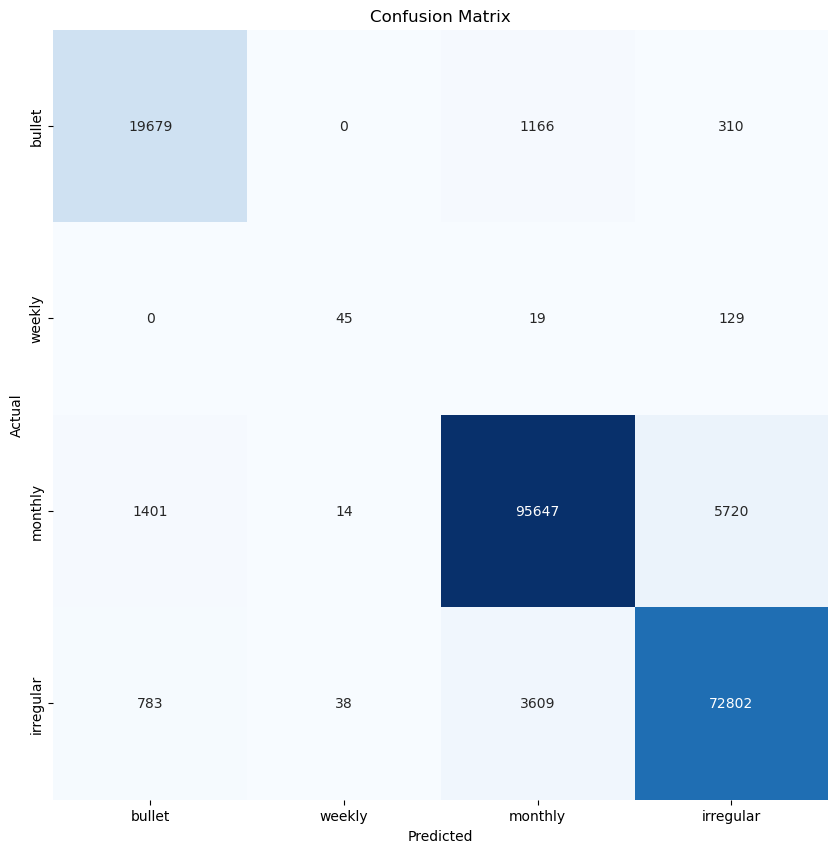

Classification Report:
------------------------------
               precision    recall  f1-score   support

      bullet       0.90      0.93      0.91     21155
      weekly       0.46      0.23      0.31       193
     monthly       0.95      0.93      0.94    102782
   irregular       0.92      0.94      0.93     77232

    accuracy                           0.93    201362
   macro avg       0.81      0.76      0.77    201362
weighted avg       0.93      0.93      0.93    201362



In [37]:
evaluate_model(model, X_test_scaled, y_test)